# Graph coloring problem
Given an undirected graph and a set of colors, color the graph so that adjacent nodes are different colors

In [1]:
# import necessary packages
import time
import numpy as np
import numpy.random as random

import dimod
import networkx as nx

from dwave.system import DWaveSampler, AutoEmbeddingComposite

# only for QUBO/classical solver
import pyqubo
from pyqubo import Binary, Constraint

import dwave.inspector

## Generate graph

5 9


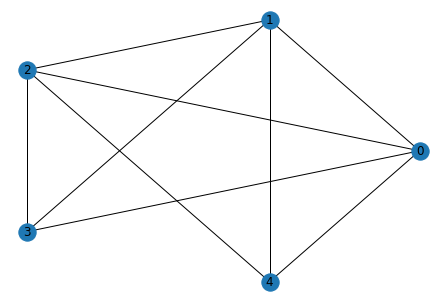

In [4]:
# generate random graph
# number of nodes
num_nodes = 5
# edge generation probability
p = 0.5
# seed (optional)
seed = 45
#generate graph
graph = nx.gnp_random_graph(num_nodes,p,seed)

pos = nx.circular_layout(graph)

# draw graph
nx.draw(graph, pos=pos, with_labels=True)

# number of colors
num_colors = max(d for _, d in graph.degree()) + 1


print(len(graph.nodes), len(graph.edges))

# graph = nx.Graph()
# graph.add_nodes_from([0,4])
# graph.add_edges_from([(0,1),(0,4),(1,2),(1,3),(1,4),(2,3),(3,4)])

# # graph.nodes.sort()
# print(type(graph.nodes))

# # house positions
# pos = {0: (0.5, 2.0), 1: (1, 1), 2: (1, 0), 3: (0, 0),  4: (0, 1)}

# nx.draw(graph, pos=pos, with_labels=True)

## Build BQM

In [43]:
# number of colors
num_colors = max(d for _, d in graph.degree()) + 1

# define variables
node_colors = [[Binary(f'({n}, {c})') for c in range(num_colors)] for n in graph.nodes]
color = [Binary(f'{c}') for c in range(num_colors)]
s = Binary('s')

P1 = 6
P2 = 4
H = 0

# objective
H = sum(color)

# color one hot
for n in graph.nodes:
    constr = 0
    for c in range(num_colors):
        constr += node_colors[n][c]*color[c]
    H += P1*Constraint((constr-1)**2, label=f'one hot{n}')

# adjacent nodes
for i,j in graph.edges:
    for c in range(num_colors):
        H += P2*Constraint(((node_colors[i][c]*color[c]+node_colors[j][c]*color[c]+s-1)), label=f'adjacent {i} {j} {c}')

model = H.compile()
Q = model.to_bqm()
print(Q.to_polystring())

-150 + 15*(3, 0) * (3, 3) + 4 + 15*2 * 4 + 15*2 * 3 + 15*(2, 2) * (2, 3) + 15*(2, 0) * (2, 1) + 15*(3, 2) * (3, 4) + 15*0 * 2 + 15*(1, 0) * (1, 2) + 15*(3, 0) * (3, 4) + 15*1 * 4 + 15*(0, 1) * (0, 4) + 2 + 1 + 15*1 * 2 + 15*(2, 1) * (2, 4) + 15*(2, 3) * (2, 4) + 15*(3, 0) * (3, 1) + 15*0 * 3 + 15*(0, 0) * (0, 3) + 15*0 * 1 + 15*(3, 3) * (3, 4) + 15*(4, 0) * (4, 1) + 15*(4, 2) * (4, 4) + 15*(4, 0) * (4, 3) + 15*(1, 0) * (1, 4) + 0 + 15*(1, 2) * (1, 3) + 15*(1, 1) * (1, 4) + 15*(0, 2) * (0, 4) + 15*(4, 1) * (4, 2) + 15*(1, 2) * (1, 4) + 15*(0, 2) * (0, 3) + 15*(1, 1) * (1, 3) + 15*(4, 3) * (4, 4) + 15*(1, 0) * (1, 3) + 15*(2, 2) * (2, 4) + 15*3 * 4 + 15*(2, 0) * (2, 3) + 15*0 * 4 + 15*(0, 0) * (0, 4) + 15*(2, 1) * (2, 2) + 15*(2, 0) * (2, 2) + 15*(4, 1) * (4, 4) + 15*(1, 1) * (1, 2) + 15*(0, 1) * (0, 3) + 15*(4, 0) * (4, 4) + 15*(0, 0) * (0, 2) + 15*(4, 0) * (4, 2) + 15*1 * 3 + 15*(4, 1) * (4, 3) + 15*(3, 1) * (3, 4) + 15*(1, 0) * (1, 1) + 15*(3, 1) * (3, 2) + 3 + 15*(3, 1) * (3, 3) + 15

## Solve

In [44]:
start = time.time()
# run QPU solver
sampler = AutoEmbeddingComposite(DWaveSampler())
response = sampler.sample(Q, num_reads=100, label='BQM Graph Coloring')
elapsed = time.time() - start
print("Solved in %.2f seconds" % elapsed)
print(response.first.sample, response.first.energy)

Solved in 6.98 seconds
{'(0, 0)': 0, '(0, 0) * (0, 1)': 0, '(0, 0) * (0, 2)': 1, '(0, 0) * (0, 3)': 0, '(0, 0) * (0, 4)': 0, '(0, 1)': 0, '(0, 1) * (0, 2)': 0, '(0, 1) * (0, 3)': 0, '(0, 1) * (0, 4)': 0, '(0, 2)': 0, '(0, 2) * (0, 3)': 0, '(0, 2) * (0, 4)': 0, '(0, 3)': 1, '(0, 3) * (0, 4)': 1, '(0, 4)': 0, '(1, 0)': 1, '(1, 0) * (1, 1)': 1, '(1, 0) * (1, 2)': 1, '(1, 0) * (1, 3)': 0, '(1, 0) * (1, 4)': 1, '(1, 1)': 1, '(1, 1) * (1, 2)': 0, '(1, 1) * (1, 3)': 0, '(1, 1) * (1, 4)': 1, '(1, 2)': 1, '(1, 2) * (1, 3)': 0, '(1, 2) * (1, 4)': 0, '(1, 3)': 0, '(1, 3) * (1, 4)': 0, '(1, 4)': 0, '(2, 0)': 1, '(2, 0) * (2, 1)': 1, '(2, 0) * (2, 2)': 1, '(2, 0) * (2, 3)': 1, '(2, 0) * (2, 4)': 0, '(2, 1)': 0, '(2, 1) * (2, 2)': 0, '(2, 1) * (2, 3)': 0, '(2, 1) * (2, 4)': 0, '(2, 2)': 1, '(2, 2) * (2, 3)': 0, '(2, 2) * (2, 4)': 0, '(2, 3)': 1, '(2, 3) * (2, 4)': 0, '(2, 4)': 0, '(3, 0)': 0, '(3, 0) * (3, 1)': 0, '(3, 0) * (3, 2)': 0, '(3, 0) * (3, 3)': 0, '(3, 0) * (3, 4)': 0, '(3, 1)': 1, '(3, 1)

## Redraw graph solution

{'(0, 0)': 0, '(0, 0) * (0, 1)': 0, '(0, 0) * (0, 2)': 1, '(0, 0) * (0, 3)': 0, '(0, 0) * (0, 4)': 0, '(0, 1)': 0, '(0, 1) * (0, 2)': 0, '(0, 1) * (0, 3)': 0, '(0, 1) * (0, 4)': 0, '(0, 2)': 0, '(0, 2) * (0, 3)': 0, '(0, 2) * (0, 4)': 0, '(0, 3)': 1, '(0, 3) * (0, 4)': 1, '(0, 4)': 0, '(1, 0)': 1, '(1, 0) * (1, 1)': 1, '(1, 0) * (1, 2)': 1, '(1, 0) * (1, 3)': 0, '(1, 0) * (1, 4)': 1, '(1, 1)': 1, '(1, 1) * (1, 2)': 0, '(1, 1) * (1, 3)': 0, '(1, 1) * (1, 4)': 1, '(1, 2)': 1, '(1, 2) * (1, 3)': 0, '(1, 2) * (1, 4)': 0, '(1, 3)': 0, '(1, 3) * (1, 4)': 0, '(1, 4)': 0, '(2, 0)': 1, '(2, 0) * (2, 1)': 1, '(2, 0) * (2, 2)': 1, '(2, 0) * (2, 3)': 1, '(2, 0) * (2, 4)': 0, '(2, 1)': 0, '(2, 1) * (2, 2)': 0, '(2, 1) * (2, 3)': 0, '(2, 1) * (2, 4)': 0, '(2, 2)': 1, '(2, 2) * (2, 3)': 0, '(2, 2) * (2, 4)': 0, '(2, 3)': 1, '(2, 3) * (2, 4)': 0, '(2, 4)': 0, '(3, 0)': 0, '(3, 0) * (3, 1)': 0, '(3, 0) * (3, 2)': 0, '(3, 0) * (3, 3)': 0, '(3, 0) * (3, 4)': 0, '(3, 1)': 1, '(3, 1) * (3, 2)': 1, '(3, 1) 

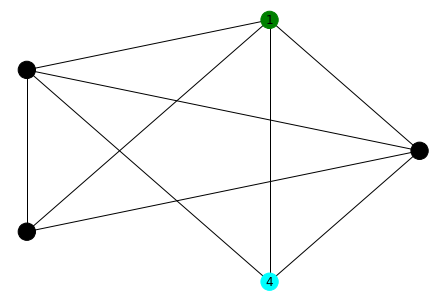

In [46]:
gcolors = ['red', 'blue', 'green', 'black', 'cyan', 'orange', 'yellow', 'purple', 'olive', 'grey']
color_map = np.empty(len(graph.nodes), dtype=object)

sorted_nodes = np.array(sorted(graph.nodes))

for n in graph.nodes:
    for c in range(num_colors):
        i = f'({n}, {c})'
        if response.first.sample[i] > 0.5:
            print(response.first.sample)
            color_map[n] = gcolors[c]
#             if response.first.sample[c] > 0.5: # get rid of double color assignment when one of the colors not used
#                 color_map[n] = gcolors[c]
        if color_map[n] is None:
            color_map[n] = "white"

print(graph.nodes)
print(color_map)
        
# draw graph
nx.draw(graph, pos=pos, node_color=color_map, with_labels=True)

In [47]:
dec = model.decode_sample(response.first.sample, vartype='BINARY')
print(dec.constraints(only_broken=True))
print(len(dec.constraints(only_broken=True)))

{'adjacent 1 2 0': (False, -1.0), 'adjacent 0 1 2': (False, -1.0), 'adjacent 2 4 3': (False, -1.0), 'adjacent 0 4 1': (False, -1.0), 'adjacent 0 3 3': (False, -1.0), 'adjacent 1 2 3': (False, -1.0), 'adjacent 0 4 4': (False, -1.0), 'adjacent 2 3 0': (False, -1.0), 'adjacent 1 3 3': (False, -1.0), 'adjacent 1 3 4': (False, -1.0), 'adjacent 1 4 2': (False, -1.0), 'adjacent 2 4 0': (False, -1.0), 'adjacent 0 4 2': (False, -1.0), 'adjacent 0 3 2': (False, -1.0), 'adjacent 2 3 1': (False, -1.0), 'adjacent 1 3 2': (False, -1.0), 'adjacent 0 2 0': (False, -1.0), 'adjacent 1 2 4': (False, -1.0), 'adjacent 2 4 1': (False, -1.0), 'adjacent 0 4 3': (False, -1.0), 'adjacent 0 2 1': (False, -1.0), 'adjacent 1 2 2': (False, -1.0), 'adjacent 0 1 4': (False, -1.0), 'adjacent 1 4 4': (False, -1.0), 'one hot3': (False, 1.0), 'adjacent 1 4 1': (False, -1.0), 'adjacent 2 3 4': (False, -1.0), 'one hot1': (False, 1.0), 'adjacent 1 3 1': (False, -1.0), 'adjacent 2 3 2': (False, -1.0), 'adjacent 0 1 0': (Fals

In [22]:
dwave.inspector.show(response)

'http://127.0.0.1:18000/?problemId=9079e903-3584-463d-9fa7-9fc7a78de0e3'